<h1> GAN - CNN</h1>

Dieses Notebook basiert auf "1_intoduce-GAN-ANN". Diesmal wird ein CNN Netz angewendet, um die Qualität zu steigern.

<i>Abb1</i>: Übersicht GAN.

<img src="./data/img/2_gan.PNG" height=500 width=700>

Als Erstes werden wir wieder nur eine Klasse nutzen und versuchen mit einem Generator basierend auf CNN ein Bild zu erzeugen.

Als Einstieg soll der Generator ein 100*100 Pixelbild eines Apfels herstellen. 

In [144]:
# Imports.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

Hier werden wir die Funktionsweise des Faltungsnetzes umkehren. Zu Beginn geben wir die Dimension des Bildes an, das dann Hochskaliert wird.

>tf.keras.layers.Conv2DTranspose:<br>
>https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose [Letzter Zugriff: 23.07.2024]

<h2>Dataset</h2>

Wir wollen mit dem Generator syntetische Apfelbilder erzeugen, für das Training nutzen wir ein Dataset das verschiedene Früchte enthählt und wählen eine Sorte aus.

> Fruits-360 dataset: A dataset with 90380 images of 131 fruits, vegetables and nuts. <br>
> https://www.kaggle.com/datasets/moltean/fruits [Letzter Zugriff: 23.07.2024]

In [148]:
url="data/datasets/archive/fruits-360_dataset/fruits-360/Training/Apple_Pink_Lady/"
img = PIL.Image.open(url+"0_100.jpg", mode='r')

In [150]:
np.asarray(img).shape

(100, 100, 3)

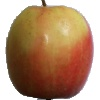

In [151]:
img

In [153]:
appleimage_names = os.listdir(url)
appleimage_names[0]

'0_100.jpg'

In [156]:
# Erstelle Numpy Dataset
apple_dataset = [np.asarray(PIL.Image.open(url+name, mode='r'))  for name in appleimage_names]
len(apple_dataset) == len(appleimage_names)

True

In [158]:
len(appleimage_names)

456

<h2>Aufbau Netz</h2>

In [208]:
image_dim = 100*100
noise_dim = 125

In [301]:
# Generator soll Bild erzeugen.
def create_generator(img_dim:int=125):
    model = tf.keras.Sequential()
    # ---- # 
    model.add(tf.keras.layers.Dense(units=25*25*256, input_shape=(img_dim, ), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape(( 25, 25, 256)))  # Model Output: (1, 12, 12, 256)
    # ---- # 
    # Transpose # 1
    model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(4,4),  padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 25, 25, 256)
    # Transpose # 2
    model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False))  # Durch Strides, Filters und Padding wird Output skaliert.
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 50, 50, 64)
    # Transpose # 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(4,4), strides=(1,1), padding='same', use_bias=False))  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())  # Model Output: (1, 50, 50, 32)


    # Transpose # 4
    #model.add(tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False))  
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.LeakyReLU())  # Model Output: 
    # Transpose # 5
    #model.add(tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=(5,5), strides=(1,2), padding='same', use_bias=False))  
    #model.add(tf.keras.layers.BatchNormalization())
    #model.add(tf.keras.layers.LeakyReLU())  
    # Transpose 6
                                              # Filters 1, 3
    model.add(tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
    # Anders als bei einem ANN muss der Output nicht extra 

    return model
    

Beim Konstruieren kann so z. B. der Output und die Form eingesehen und weitere Informationen ausgegeben werden.

Der Aufbau hier ist wieder recht simpel, wenn es darum geht nur eine Klasse eines Bildes zu erzeugen.

In [375]:
noise = np.random.normal(0, 1, (1, 125))  
generator = create_generator(noise_dim)
img = generator(noise)
img.shape

TensorShape([1, 100, 100, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022444533..0.022968179].


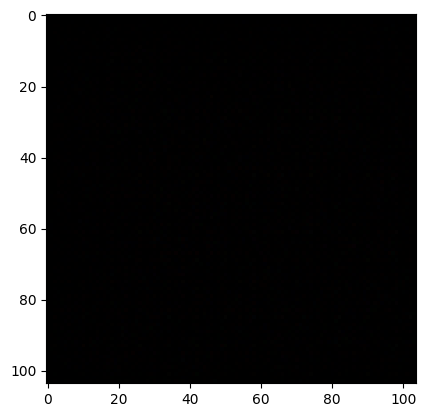

In [259]:
plt.imshow(img[0])

Jetzt kommt der Discriminator.

In [303]:
def create_discriminator():
    model = tf.keras.Sequential()
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(1,1), input_shape=(100,100,3), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.2))
    # --- # 
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    return model
    

In [304]:
discriminator = create_discriminator()
discriminator.build(input_shape=(1,104,104,3))
discriminator.summary()

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 100, 100, 64)      3136      
                                                                 
 leaky_re_lu_295 (LeakyReLU)  (None, 100, 100, 64)     0         
                                                                 
 dropout_42 (Dropout)        (None, 100, 100, 64)      0         
                                                                 
 conv2d_48 (Conv2D)          (None, 100, 100, 32)      8224      
                                                                 
 leaky_re_lu_296 (LeakyReLU)  (None, 100, 100, 32)     0         
                                                                 
 dropout_43 (Dropout)        (None, 100, 100, 32)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 100, 100, 16)    

In [305]:
img.shape

TensorShape([1, 100, 100, 3])

In [306]:
discriminator(img)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.49982595]], dtype=float32)>

In [309]:
discriminator(apple_dataset_numpy[0].reshape((-1, 100, 100, 3)))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.52365184]], dtype=float32)>

<h2>Training 1</h2>

Danach erstellen wir das GAN-Netzwerk und trainieren es.

In [415]:
# Erstelle Modelle. 
generator     = create_generator()
discriminator = create_discriminator()

In [416]:
# Kompiliere Modelle.
generator.compile(optimizer='adam', loss='binary_crossentropy')

discriminator.compile(
    optimizer = 'adam',
    loss      = 'binary_crossentropy'
)

In [316]:
tf.convert_to_tensor(apple_dataset_numpy[1].reshape((-1, 100, 100, 3)))

<tf.Tensor: shape=(1, 100, 100, 3), dtype=float64, numpy=
array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]]])>

In [ ]:
discriminator.train_on_batch

In [409]:

def train(real_images, generator, discriminator, batch_size:int=16, epoches:int=10):

    half_batch = int(batch_size / 2)  
    
    for epoch in range(epoches):
        
        index       = np.random.randint(0, real_images.shape[0], half_batch)
        real_images = real_images[[4,5,6,7]]#.reshape((-1, 100, 100, 3))
        noise       = np.random.normal(0, 1, (half_batch, 125)) 
        
        # Discriminator # 
        with tf.GradientTape() as d_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)
            
            #loss_real = discriminator.train_on_batch(tf.ones_like(real_images) ,tf.convert_to_tensor(real_images))  
            #loss_fake = discriminator.train_on_batch(tf.zeros_like(fake_images),fake_output )
            loss_real = discriminator.train_on_batch(real_images , np.ones(  (half_batch, 1)))  
            loss_fake = discriminator.train_on_batch(generated_images, np.zeros( (half_batch, 1) )) 
            d_loss = 0.5 * np.add(loss_real, loss_fake) 

        d_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
        discriminator.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

        #  Generator # 
        with tf.GradientTape() as g_tape:
            generated_images = generator(noise, training=True)
            fake_output      = discriminator(generated_images, training=True)
            g_loss           = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

        g_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
        generator.optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

        printf("d_loss: {d_loss}, {g_loss}: g_loss")

In [386]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

<h2>Training 2</h2>

In [115]:
def create_GAN(gen, disc):
    # Kombiniere.
    gan_input   = tf.keras.layers.Input(shape=(125,))  
    gen_output = generator(gan_input)

    disc_output = discriminator(gen_output)
    GAN         = tf.keras.Model(gan_input, disc_output)

    GAN.compile(optimizer='adam', loss='binary_crossentropy')